In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
%matplotlib inline
plt.style.use("ggplot")

In [2]:
def readTsvDates(base_dir, app_name, date_from, date_to):
    date_from = datetime.strptime(date_from, "%Y-%m-%d")
    date_to = datetime.strptime(date_to, "%Y-%m-%d")
    dates = [str(date_from + timedelta(d)).split()[0] for d in range ((date_to - date_from).days + 1)]
    x = pd.DataFrame()
    for day in dates:
        tmp = pd.read_csv("%s/%s/%s/data.tsv" % (base_dir, app_name, day), sep = "\t")
        x = pd.concat([x, tmp], axis = 0)
    return x

In [3]:
def readDau(app_name, date_from, date_to = None):
    if date_to is None:
        date_to = date_from
    data = readTsvDates("R/sample-data/section8/daily/dau", app_name, date_from, date_to)
    return data

In [4]:
def readDpu(app_name, date_from, date_to = None):
    if date_to is None:
        date_to = date_from
    data = readTsvDates("R/sample-data/section8/daily/dpu", app_name, date_from, date_to)
    return data

In [5]:
def readActionDaily(app_name, date_from, date_to = None):
    if date_to is None:
        date_to = date_from
    data = readTsvDates("R/sample-data/section8/daily/action", app_name, date_from, date_to)
    return data

In [6]:
dau = readDau("game-01", "2013-05-01", "2013-10-31")
dau.head()

,log_date,app_name,user_id
0,2013-05-01,game-01,608801
1,2013-05-01,game-01,712453
2,2013-05-01,game-01,776853
3,2013-05-01,game-01,823486
4,2013-05-01,game-01,113600


In [7]:
dpu = readDpu("game-01", "2013-05-01", "2013-10-31")
dpu.head()

,log_date,app_name,user_id,payment
0,2013-05-01,game-01,804005,571
1,2013-05-01,game-01,793537,81
2,2013-05-01,game-01,317717,81
3,2013-05-01,game-01,317717,81
4,2013-05-01,game-01,426525,324


In [8]:
user_action = readActionDaily("game-01", "2013-10-31", "2013-10-31")
user_action.head()

,log_date,app_name,user_id,A1,A2,A3,A4,A5,A6,A7,...,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54
0,2013-10-31,game-01,654133,0,0,0,0,0,0,0,...,0,0,380,25655,0,0,0,0,0.0,46
1,2013-10-31,game-01,425530,0,0,0,0,10,1,233,...,19,20,180543,347,36,22,4,0,0.0,71
2,2013-10-31,game-01,709596,0,0,0,0,0,0,0,...,0,0,416,24817,0,0,0,0,0.0,2
3,2013-10-31,game-01,525047,0,2,0,0,9,0,0,...,22,22,35200,6412,21,0,0,0,0.0,109
4,2013-10-31,game-01,796908,0,0,0,0,0,0,0,...,29,29,388,25444,1,0,0,0,0.0,64


In [9]:
dau2 = pd.merge(dau, dpu[["log_date", "user_id", "payment"]], on = ["log_date", "user_id"], how = "left")

dau2["is_payment"] = np.where(dau2["payment"].isnull(), 0 ,1)
dau2.head()

,log_date,app_name,user_id,payment,is_payment
0,2013-05-01,game-01,608801,NaN,0
1,2013-05-01,game-01,712453,NaN,0
2,2013-05-01,game-01,776853,NaN,0
3,2013-05-01,game-01,823486,NaN,0
4,2013-05-01,game-01,113600,NaN,0


In [10]:
dau2["payment"] = np.where(dau2["payment"].isnull(), 0, dau2["payment"])
dau2.head()

,log_date,app_name,user_id,payment,is_payment
0,2013-05-01,game-01,608801,0.0,0
1,2013-05-01,game-01,712453,0.0,0
2,2013-05-01,game-01,776853,0.0,0
3,2013-05-01,game-01,823486,0.0,0
4,2013-05-01,game-01,113600,0.0,0


In [11]:
dau2["log_month"] = dau2["log_date"].str.slice(0,7)

mau = dau2.groupby(["log_month", "user_id"]).agg({"payment": "sum", "log_date": "count"}).reset_index()
mau.columns = {"log_month", "user_id", "payment", "log_date"}
mau.head()

,user_id,log_month,payment,log_date
0,2013-05,65,0.0,1
1,2013-05,115,0.0,1
2,2013-05,194,0.0,1
3,2013-05,426,0.0,4
4,2013-05,539,0.0,1


In [12]:
user_action["cluster"] = KMeans(n_clusters = 3, random_state = 0).fit_predict(user_action[["A47"]])
user_action[["user_id", "cluster"]].groupby("cluster").count()

,user_id
cluster,
0,2096
1,479
2,78


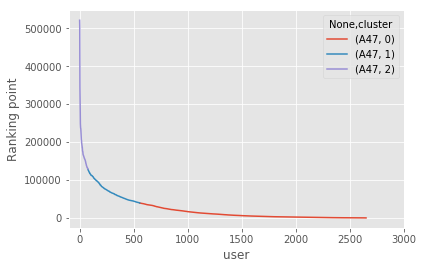

In [14]:
user_action2 = user_action.sort_values(by = "A47", ascending = False).reset_index().drop("index", axis = 1)
user_action2["index"] = user_action2.index
user_action2[["index", "A47", "cluster"]].groupby(["index", "cluster"]).max().unstack().plot()
plt.xlabel("user")
plt.ylabel("Ranking point")
plt.xlim(-100, 3000)
plt.show()

In [15]:
user_action_h = user_action2.query("cluster >= 1").drop(["cluster", "index"], axis = 1)
user_action_h.head()

,log_date,app_name,user_id,A1,A2,A3,A4,A5,A6,A7,...,A45,A46,A47,A48,A49,A50,A51,A52,A53,A54
0,2013-10-31,game-01,484271,0,0,0,0,5,2,75,...,35,36,521032,21,41,26,3,0,0.0,209
1,2013-10-31,game-01,401902,0,0,0,0,7,0,0,...,22,22,505691,23,26,3,0,0,0.0,85
2,2013-10-31,game-01,150752,0,0,0,0,11,1,60,...,15,15,380340,35,19,3,1,1,1.0,52
3,2013-10-31,game-01,196570,0,0,0,0,12,0,0,...,19,29,344958,43,47,42,0,0,0.0,305
4,2013-10-31,game-01,705026,0,0,0,0,8,0,257,...,41,41,316022,54,27,12,3,0,0.0,318
